In [1]:
#load our friends
import numpy as np
import math as mt 
import lmfit
import csv
import scipy.stats as sta
import matplotlib.pyplot as plt
from lmfit import Minimizer, Parameters
from lmfit.lineshapes import gaussian
from lmfit.printfuncs import report_fit

In [3]:
#define a polynomial with a guassian note polyval is a pre-coded polynomial
def polgaus(x, p0, p1, p2, p3, p4, p5, norm, mu, sigma):
    pols=[p0,p1,p2,p3,p4,p5]
    y = norm*(np.exp(-np.power((x-mu),2.)/(2.*sigma**2)))+ np.polyval(pols,x)
    return y

#define just a polynomial
def polback(x, p0, p1, p2, p3, p4, p5):
    pols=[p0,p1,p2,p3,p4,p5]
    y = np.polyval(pols,x)
    return y

def gaus(x,norm,mu,sigma):
    y = norm*(np.exp(-np.power((x-mu),2.)/(2.*sigma**2)))
    return y

In [28]:
#run the fit
def fitFile_fancy(label,outname, mu=3800,vary_mu=True):
    x = []
    y = []
    y_err = []
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=' ')
        for row in plots:
            print('debug',row[1],row[2])
            if float(row[1]) < 50:
                    continue
            x.append(float(row[1]))
            y.append(float(row[2]))
            #add poisson uncertainties                                                                                                                                                                                                       
            y_err.append(mt.sqrt(float(row[2])))
    #Dumb trick to get uncertaities                                                                                                                                                                                                           
    weights = np.linspace(0.,len(y),num=len(y))
    for i0 in range(len(y)):
        weights[i0] = float(1./y_err[i0])
    #Now setup the fit (for signal+background)
    poly_mod = lmfit.Model(polback,prefix='pol_')
    
    #pars = poly_mod.guess(y, x=x)
    
    gauss1 = lmfit.Model(gaus,prefix='g1_')
    #gauss2 = lmfit.Model(gaus,prefix='g2_')
    
    pars = poly_mod.make_params(p0=-3.48924610e-06,p1=2.79987292e-03,p2=-9.00945726e-01,p3=1.45645139e+02,p4=-1.18689484e+04,p5=3.92197860e+05)
    pars.update(gauss1.make_params(norm=10,mu=mu,sigma=40))
    #pars.update(gauss2.make_params(norm=609.0,mu=mu_2,sigma=13.4))
    
    print(pars)
    #p = model.make_params(p0=-3.48924610e-06,p1=2.79987292e-03,p2=-9.00945726e-01,p3=1.45645139e+02,p4=-1.18689484e+04,p5=3.92197860e+05,
    #                      norm_1=305.04,mu_1=mu_1,sigma_1=4.5,norm_2=609.0,mu_2=mu_2,sigma_2=13.4)
    pars['g1_mu'].set(value = mu, min =3000.,max = 6000.,vary=vary_mu)
    #pars['g2_mu'].set(value = mu_2, min =50.,max = 160.,vary=vary_mu)
    mod = poly_mod+gauss1
    #init = mod.eval(pars, x=x, weights=weights)
    result = mod.fit(y, pars, x=x, weights=weights)
    #plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(x, y, 'b')
    #axes[0].plot(x, init, 'k--', label='initial fit')
    axes[0].plot(x, result.best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')
    
    comps = result.eval_components(x=x)
    axes[1].plot(x, y, 'b')
    axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component')
    #axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
    axes[1].plot(x, comps['pol_'], 'k--', label='Polynomial background')
    axes[1].legend(loc='best')

    labels_x = "mass[GeV]"
    labels_y = "Entries/bin"
    #result.plot()
    plt.xlabel(labels_x,position=(0.92,0.1))
    plt.ylabel(labels_y,position=(0.1,0.84))
    plt.savefig(outname+'.png')
    print(result.fit_report())
    return result.chisqr

In [29]:
#run the fit
def fitFile(label,mu=3800,vary_mu=True):
    x = []
    y = []
    y_err = []
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=' ')
        for row in plots:
            print('debug',row[1],row[2])
            if float(row[1]) < 50:
                    continue
            x.append(float(row[1]))
            y.append(float(row[2]))
            #add poisson uncertainties                                                                                                                                                                                                       
            y_err.append(mt.sqrt(float(row[2])))
    #Dumb trick to get uncertaities                                                                                                                                                                                                           
    weights = np.linspace(0.,len(y),num=len(y))
    for i0 in range(len(y)):
        weights[i0] = float(1./y_err[i0])
    #Now setup the fit (for signal+background)
    model = lmfit.Model(polgaus)
    p = model.make_params(p0=-3.48924610e-06,p1=2.79987292e-03,p2=-9.00945726e-01,p3=1.45645139e+02,p4=-1.18689484e+04,p5=3.92197860e+05,norm=3.53117893e+01,mu=mu,sigma=2.5)
    p['mu'].set(vary=vary_mu)
    result = model.fit(data=y, params=p, x=x, weights=weights)
    plt.figure()
    labels_x = "mass[GeV]"
    labels_y = "Entries/bin"
    result.plot()
    plt.xlabel(labels_x,position=(0.92,0.1))
    plt.ylabel(labels_y,position=(0.1,0.84))
    print(result.fit_report())
    return result.chisqr

In [30]:
#run the fit
def fitFile_doublegaus_fancy(label,outname,mu_1=80.38,mu_2=91.1876,vary_mu=True):
    x = []
    y = []
    y_err = []
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=' ')
        for row in plots:
            #print('debug',row[1],row[2])
            if float(row[1]) < 52:
                    continue
            x.append(float(row[1]))
            y.append(float(row[2]))
            #add poisson uncertainties                                                                                                                                                                                                       
            y_err.append(mt.sqrt(float(row[2])))
    #Dumb trick to get uncertaities                                                                                                                                                                                                           
    weights = np.linspace(0.,len(y),num=len(y))
    for i0 in range(len(y)):
        weights[i0] = float(1./y_err[i0])
    #Now setup the fit (for signal+background)
    #model = lmfit.Model(poldoublegaus)
    poly_mod = lmfit.Model(polback,prefix='pol_')
    
    #pars = poly_mod.guess(y, x=x)
    
    gauss1 = lmfit.Model(gaus,prefix='g1_')
    gauss2 = lmfit.Model(gaus,prefix='g2_')
    
    pars = poly_mod.make_params(p0=-3.48924610e-06,p1=2.79987292e-03,p2=-9.00945726e-01,p3=1.45645139e+02,p4=-1.18689484e+04,p5=3.92197860e+05)
    pars.update(gauss1.make_params(norm=305.04,mu=mu_1,sigma=4.5))
    pars.update(gauss2.make_params(norm=609.0,mu=mu_2,sigma=13.4))
    
    print(pars)
    #p = model.make_params(p0=-3.48924610e-06,p1=2.79987292e-03,p2=-9.00945726e-01,p3=1.45645139e+02,p4=-1.18689484e+04,p5=3.92197860e+05,
    #                      norm_1=305.04,mu_1=mu_1,sigma_1=4.5,norm_2=609.0,mu_2=mu_2,sigma_2=13.4)
    pars['g1_mu'].set(value = mu_1, min =50.,max = 160.,vary=vary_mu)
    pars['g2_mu'].set(value = mu_2, min =50.,max = 160.,vary=vary_mu)
    mod = poly_mod+gauss1+gauss2
    #init = mod.eval(pars, x=x, weights=weights)
    result = mod.fit(y, pars, x=x, weights=weights)
    #plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axes[0].plot(x, y, 'b')
    #axes[0].plot(x, init, 'k--', label='initial fit')
    axes[0].plot(x, result.best_fit, 'r-', label='best fit')
    axes[0].legend(loc='best')
    
    comps = result.eval_components(x=x)
    axes[1].plot(x, y, 'b')
    axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
    axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
    axes[1].plot(x, comps['pol_'], 'k--', label='Polynomial background')
    axes[1].legend(loc='best')

    labels_x = "mass[GeV]"
    labels_y = "Entries/bin"
    #result.plot()
    plt.xlabel(labels_x,position=(0.92,0.1))
    plt.ylabel(labels_y,position=(0.1,0.84))
    plt.savefig(outname+'.png')
    print(result.fit_report())
    return result.chisqr

debug 2800.0 255.0
debug 2900.0 243.0
debug 3000.0 192.0
debug 3100.0 204.0
debug 3200.0 184.0
debug 3300.0 205.0
debug 3400.0 202.0
debug 3500.0 171.0
debug 3600.0 139.0
debug 3700.0 141.0
debug 3800.0 140.0
debug 3900.0 117.0
debug 4000.0 121.0
debug 4100.0 101.0
debug 4200.0 90.0
debug 4300.0 60.0
debug 4400.0 58.0
debug 4500.0 58.0
debug 4600.0 47.0
debug 4700.0 38.0
debug 4800.0 36.0
debug 4900.0 35.0
debug 5000.0 25.0
debug 5100.0 24.0
debug 5200.0 17.0
debug 5300.0 12.0
debug 5400.0 13.0
debug 5500.0 14.0
debug 5600.0 10.0
debug 5700.0 10.0
debug 5800.0 6.0
debug 5900.0 8.0
debug 6000.0 8.0
debug 6100.0 2.0
debug 6200.0 4.0
debug 6300.0 3.0
debug 6400.0 6.0
debug 6500.0 2.0
debug 6600.0 3.0
Parameters([('pol_p0', <Parameter 'pol_p0', value=-3.4892461e-06, bounds=[-inf:inf]>), ('pol_p1', <Parameter 'pol_p1', value=0.00279987292, bounds=[-inf:inf]>), ('pol_p2', <Parameter 'pol_p2', value=-0.900945726, bounds=[-inf:inf]>), ('pol_p3', <Parameter 'pol_p3', value=145.645139, bounds=[-

28.425920759315957

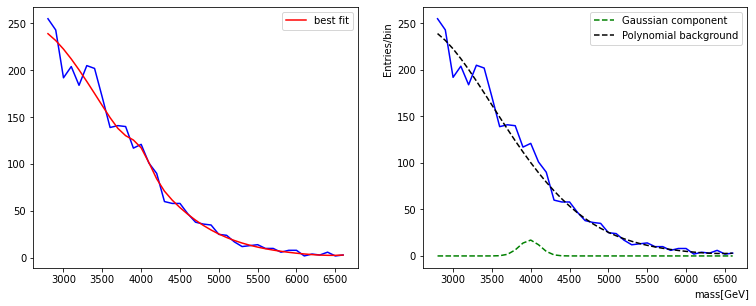

In [31]:
fitFile_fancy("blackbox2_hist.txt",'bb2',4000)